# How to Train YOLOv7 on a Custom Dataset

This tutorial is based on the [YOLOv7 repository](https://github.com/WongKinYiu/yolov7) by WongKinYiu. This notebook shows training on **your own custom objects**. Many thanks to WongKinYiu and AlexeyAB for putting this repository together.


### **Accompanying Blog Post**

We recommend that you follow along in this notebook while reading the blog post on [how to train YOLOv7](https://blog.roboflow.com/yolov7-custom-dataset-training-tutorial/), concurrently.

### **Steps Covered in this Tutorial**

To train our detector we take the following steps:

* Install YOLOv7 dependencies
* Load custom dataset from Roboflow in YOLOv7 format
* Run YOLOv7 training
* Evaluate YOLOv7 performance
* Run YOLOv7 inference on test images
* OPTIONAL: Deployment
* OPTIONAL: Active Learning


### Preparing a Custom Dataset

In this tutorial, we will utilize an open source computer vision dataset from one of the 90,000+ available on [Roboflow Universe](https://universe.roboflow.com).

If you already have your own images (and, optionally, annotations), you can convert your dataset using [Roboflow](https://roboflow.com), a set of tools developers use to build better computer vision models quickly and accurately. 100k+ developers use roboflow for (automatic) annotation, converting dataset formats (like to YOLOv7), training, deploying, and improving their datasets/models.

Follow [the getting started guide here](https://docs.roboflow.com/quick-start) to create and prepare your own custom dataset.

#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [14]:
# Download YOLOv7 repository and install requirements
!pwd
!git clone https://github.com/WongKinYiu/yolov7
%cd yolov7
!python3.9 -m pip install -r requirements.txt

/home/trymg/Dropbox/master/semester 3/IT3915 Master preparatory project
Cloning into 'yolov7'...
remote: Enumerating objects: 975, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 975 (delta 2), reused 6 (delta 0), pack-reused 963
Receiving objects: 100% (975/975), 68.18 MiB | 3.32 MiB/s, done.
Resolving deltas: 100% (505/505), done.
/home/trymg/Dropbox/master/semester 3/IT3915 Master preparatory project/yolov7
Defaulting to user installation because normal site-packages is not writeable


# Download Correctly Formatted Custom Data

Next, we'll download our dataset in the right format. Use the `YOLOv7 PyTorch` export. Note that this model requires YOLO TXT annotations, a custom YAML file, and organized directories. The roboflow export writes this for us and saves it in the correct spot.


In [15]:
# REPLACE with your custom code snippet generated above
# !ls

!python3.9 -m pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Sf4Q132h8vYyzxbVfF7t")
print(rf.workspace().projects()) # for debugging
project = rf.workspace("it3915masterpreparatoryproject").project("sheep-detection-from-above")
dataset = project.version(2).download("yolov7")

Defaulting to user installation because normal site-packages is not writeable
loading Roboflow workspace...
['it3915masterpreparatoryproject/sheep-detection-2', 'it3915masterpreparatoryproject/sheep-detection-from-above', 'it3915masterpreparatoryproject/test-omkqq']
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Sheep-detection-from-above-2 in yolov7pytorch:: 100%|██████████| 4048/4048 [00:00<00:00, 6727.45it/s]


# Custom image augmentation using Albumentations

## Augmentation plot utils

In [11]:
import random
import cv2
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np
import albumentations as A


def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)
    plt.show()


def plot_examples(images, bboxes=None):
    fig = plt.figure(figsize=(15, 15))
    columns = 4
    rows = 5

    for i in range(1, len(images)):
        if bboxes is not None:
            img = visualize_bbox(images[i - 1], bboxes[i - 1], class_name="Elon")
        else:
            img = images[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()


# From https://albumentations.ai/docs/examples/example_bboxes/
def visualize_bbox(img, bbox, class_name, color=(255, 0, 0), thickness=5):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = map(int, bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, thickness)
    return img

## Augmentation classification

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


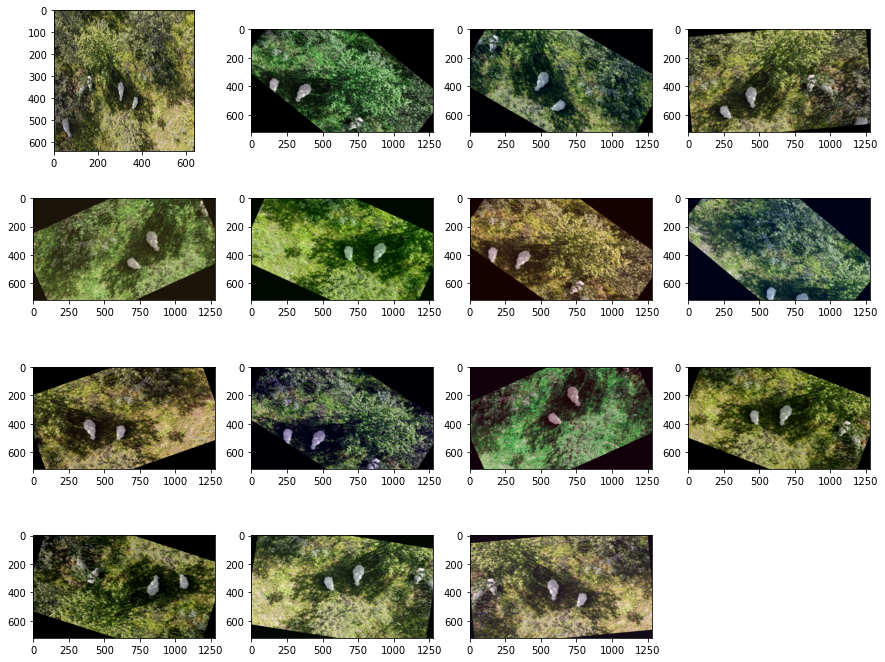

In [17]:
!python3.9 -m pip install albumentations 
!python3.9 -m pip install opencv-python

import cv2
import albumentations as A
import numpy as np
from PIL import Image

image = Image.open("Sheep-detection-from-above-2/train/images/2019_08_storli1_0704_jpg.rf.8a36a1432b846d665cc2454faf1a8dd0.jpg")

transform = A.Compose(
    [
        A.Resize(width=1920, height=1080),
        A.RandomCrop(width=1280, height=720),
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.ColorJitter(p=0.5),
        ], p=1.0),
    ]
)

images_list = [image]
image = np.array(image)
for i in range(15):
    augmentations = transform(image=image)
    augmented_img = augmentations["image"]
    images_list.append(augmented_img)
plot_examples(images_list)





# Begin Custom Training

We're ready to start custom training.

NOTE: We will only modify one of the YOLOv7 training defaults in our example: `epochs`. We will adjust from 300 to 100 epochs in our example for speed. If you'd like to change other settings, see details in [our accompanying blog post](https://blog.roboflow.com/yolov7-custom-dataset-training-tutorial/).

In [ ]:
# download COCO starting checkpoint (weights)
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt

In [ ]:
# run this cell to begin training
!pwd
# !rm runs/train/* -rf # image results from previous runs are deleted

!python3.9 train.py --batch-size 16 --epochs 100 --data Sheep-detection-from-above-2/data.yaml --weights 'yolov7-tiny.pt' --device 0 


# Evaluation

We can evaluate the performance of our custom training using the provided evalution script.

Note we can adjust the below custom arguments. For details, see [the arguments accepted by detect.py](https://github.com/WongKinYiu/yolov7/blob/main/detect.py#L154).

In [ ]:
# %cd yolov7
# %pwd

In [ ]:
# Run evaluation
# !python3.9 detect.py --weights runs/train/exp/weights/best.pt --conf 0.5 --source Sheep-detection-from-above-2/test/images
!python3.9 detect.py --weights runs/train//weights/best.pt --conf 0.5 --source Sheep-detection-from-above-2/test/images


In [ ]:
#display inference on ALL test images

import glob
from IPython.display import Image, display

i = 0
limit = 10000 # max images to print
for imageName in glob.glob('runs/detect/exp/*.jpg'): #assuming JPG
    print(imageName)
    if i < limit:
      display(Image(filename=imageName))
      print("\n")
    i = i + 1
    

# Reparameterize for Inference

https://github.com/WongKinYiu/yolov7/blob/main/tools/reparameterization.ipynb

# OPTIONAL: Deployment

To deploy, you'll need to export your weights and save them to use later.

In [ ]:
# optional, zip to download weights and results locally

!zip -r export.zip runs/detect
!zip -r export.zip runs/train/exp/weights/best.pt
!zip export.zip runs/train/exp/*

# OPTIONAL: Active Learning Example

Once our first training run is complete, we should use our model to help identify which images are most problematic in order to investigate, annotate, and improve our dataset (and, therefore, model).

To do that, we can execute code that automatically uploads images back to our hosted dataset if the image is a specific class or below a given confidence threshold.


In [ ]:
# # setup access to your workspace
# rf = Roboflow(api_key="YOUR_API_KEY")                               # used above to load data
# inference_project =  rf.workspace().project("YOUR_PROJECT_NAME")    # used above to load data
# model = inference_project.version(1).model

# upload_project = rf.workspace().project("YOUR_PROJECT_NAME")

# print("inference reference point: ", inference_project)
# print("upload destination: ", upload_project)

In [ ]:
# # example upload: if prediction is below a given confidence threshold, upload it 

# confidence_interval = [10,70]                                   # [lower_bound_percent, upper_bound_percent]

# for prediction in predictions:                                  # predictions list to loop through
#   if(prediction['confidence'] * 100 >= confidence_interval[0] and 
#           prediction['confidence'] * 100 <= confidence_interval[1]):
        
#           # upload on success!
#           print(' >> image uploaded!')
#           upload_project.upload(image, num_retry_uploads=3)     # upload image in question

# Next steps

Congratulations, you've trained a custom YOLOv7 model! Next, start thinking about deploying and [building an MLOps pipeline](https://docs.roboflow.com) so your model gets better the more data it sees in the wild.